# 🚀 LangGraph Campaign Assistant

## Interactive Graph Development with Jupyter Notebooks

This notebook provides a complete implementation of the Campaign Assistant using LangGraph. We'll build, test, and visualize the agent graph interactively without needing external studio tools.

### What You'll Build:
- **Query Analyzer**: Understands user intent and extracts requirements
- **Data Retriever**: Fetches relevant campaign data based on queries  
- **Response Generator**: Creates comprehensive, formatted responses
- **Graph Visualizer**: Interactive visualization of the agent workflow

### Benefits of Notebook Approach:
- ✅ **Interactive Development**: Test each component as you build
- ✅ **Visual Debugging**: See graph structure and execution flow
- ✅ **Flexible Environment**: No Docker or external dependencies
- ✅ **Easy Iteration**: Modify and test agents quickly

## 📦 Environment Setup & Imports

First, let's import all the necessary libraries and set up our environment.

In [20]:
# Core imports for LangGraph
import os
import sys
from typing import TypedDict, Annotated, List, Dict, Any, Optional
from datetime import datetime
import json

# LangGraph imports
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

# Visualization imports
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display, HTML, Markdown, Image
import warnings
warnings.filterwarnings('ignore')

# Set up environment
os.environ['PYTHONPATH'] = os.path.abspath('..')
sys.path.insert(0, os.path.abspath('..'))

print("✅ Environment setup complete!")
print(f"📍 Working directory: {os.getcwd()}")
print(f"🐍 Python version: {sys.version.split()[0]}")

# Check if we're in the right directory
if os.path.exists('../app'):
    print("✅ Project structure detected")
else:
    print("⚠️ Run this notebook from the agents/ directory")

✅ Environment setup complete!
📍 Working directory: /Users/lolo/shared/projects/turing/sprint-3/project-23/agents
🐍 Python version: 3.12.11
✅ Project structure detected


## 🔧 Graph State Definition

Define the state structure that will flow through our agent graph. This represents the data that gets passed between different nodes in our workflow.

In [12]:
class CampaignAssistantState(TypedDict):
    """
    State object that flows through the campaign assistant graph.
    
    This contains all the information needed for the agent to process
    user queries and generate responses about campaign data.
    """
    # Core conversation state
    messages: Annotated[List[BaseMessage], add_messages]
    
    # Query processing
    user_query: str
    query_type: str  # e.g., "performance", "analysis", "comparison"
    extracted_entities: Dict[str, Any]  # campaign names, date ranges, metrics
    
    # Data retrieval
    relevant_data: Dict[str, Any]
    data_sources: List[str]
    
    # Response generation
    response: str
    charts_generated: List[str]
    
    # Workflow control
    current_step: str
    needs_data: bool
    error_message: Optional[str]

# Example state for testing
sample_state = CampaignAssistantState(
    messages=[],
    user_query="",
    query_type="",
    extracted_entities={},
    relevant_data={},
    data_sources=[],
    response="",
    charts_generated=[],
    current_step="start",
    needs_data=False,
    error_message=None
)

print("✅ Graph state defined!")
print(f"📋 State fields: {list(sample_state.keys())}")
display(Markdown("**State Structure:**"))
for key, value in sample_state.items():
    print(f"• `{key}`: {type(value).__name__}")

✅ Graph state defined!
📋 State fields: ['messages', 'user_query', 'query_type', 'extracted_entities', 'relevant_data', 'data_sources', 'response', 'charts_generated', 'current_step', 'needs_data', 'error_message']


**State Structure:**

• `messages`: list
• `user_query`: str
• `query_type`: str
• `extracted_entities`: dict
• `relevant_data`: dict
• `data_sources`: list
• `response`: str
• `charts_generated`: list
• `current_step`: str
• `needs_data`: bool
• `error_message`: NoneType


## 🧠 Agent Node Functions

Now let's define the core functions that will process user queries. Each function represents a node in our graph and performs a specific task.

In [13]:
def query_analyzer(state: CampaignAssistantState) -> CampaignAssistantState:
    """
    Analyze the user query to understand intent and extract entities.
    
    This node determines:
    - What type of query this is (performance, analysis, comparison)
    - What entities are mentioned (campaign names, metrics, date ranges)
    - Whether we need to retrieve data
    """
    print("🔍 Analyzing user query...")
    
    query = state.get("user_query", "")
    
    # Simple rule-based analysis (in production, use LLM)
    query_lower = query.lower()
    
    # Determine query type
    if any(word in query_lower for word in ["performance", "metrics", "conversion", "ctr", "spend"]):
        query_type = "performance"
        needs_data = True
    elif any(word in query_lower for word in ["compare", "vs", "versus", "difference"]):
        query_type = "comparison"
        needs_data = True
    elif any(word in query_lower for word in ["analyze", "analysis", "insights", "trends"]):
        query_type = "analysis"
        needs_data = True
    else:
        query_type = "general"
        needs_data = False
    
    # Extract entities (simplified)
    entities = {}
    if "campaign" in query_lower:
        # In production, use NER to extract actual campaign names
        entities["campaigns"] = ["campaign_1", "campaign_2"]
    
    print(f"   Query type: {query_type}")
    print(f"   Needs data: {needs_data}")
    print(f"   Entities: {entities}")
    
    return {
        **state,
        "query_type": query_type,
        "extracted_entities": entities,
        "needs_data": needs_data,
        "current_step": "query_analyzed"
    }

# Test the analyzer
test_state = {
    "user_query": "Show me the performance metrics for our recent campaigns",
    "messages": [HumanMessage(content="Show me the performance metrics for our recent campaigns")],
    "current_step": "start"
}

result = query_analyzer(test_state)
print(f"\n✅ Query analysis complete! Type: {result['query_type']}")

🔍 Analyzing user query...
   Query type: performance
   Needs data: True
   Entities: {'campaigns': ['campaign_1', 'campaign_2']}

✅ Query analysis complete! Type: performance


In [14]:
def data_retriever(state: CampaignAssistantState) -> CampaignAssistantState:
    """
    Retrieve relevant campaign data based on the analyzed query.
    
    This node:
    - Fetches data from databases, CSVs, or APIs
    - Filters data based on extracted entities
    - Prepares data for response generation
    """
    print("📊 Retrieving campaign data...")
    
    query_type = state.get("query_type", "")
    entities = state.get("extracted_entities", {})
    
    # Mock data retrieval (in production, query actual databases)
    mock_data = {
        "campaigns": [
            {
                "name": "Summer Sale 2024",
                "spend": 15000,
                "impressions": 250000,
                "clicks": 5000,
                "conversions": 150,
                "ctr": 2.0,
                "conversion_rate": 3.0
            },
            {
                "name": "Black Friday 2024",
                "spend": 25000,
                "impressions": 400000,
                "clicks": 8000,
                "conversions": 320,
                "ctr": 2.0,
                "conversion_rate": 4.0
            }
        ],
        "date_range": "2024-01-01 to 2024-12-31",
        "total_spend": 40000,
        "total_conversions": 470
    }
    
    # Filter data based on query type
    if query_type == "performance":
        relevant_data = {
            "metrics": ["spend", "impressions", "clicks", "conversions", "ctr"],
            "campaigns": mock_data["campaigns"]
        }
    elif query_type == "comparison":
        relevant_data = {
            "comparison_data": mock_data["campaigns"],
            "metrics_to_compare": ["spend", "conversions", "ctr"]
        }
    else:
        relevant_data = mock_data
    
    data_sources = ["campaign_database", "analytics_api"]
    
    print(f"   Retrieved data for {len(mock_data['campaigns'])} campaigns")
    print(f"   Data sources: {data_sources}")
    
    return {
        **state,
        "relevant_data": relevant_data,
        "data_sources": data_sources,
        "current_step": "data_retrieved"
    }

# Test the data retriever
test_state_with_analysis = {**result, "needs_data": True}
data_result = data_retriever(test_state_with_analysis)
print(f"\n✅ Data retrieval complete! Sources: {data_result['data_sources']}")

📊 Retrieving campaign data...
   Retrieved data for 2 campaigns
   Data sources: ['campaign_database', 'analytics_api']

✅ Data retrieval complete! Sources: ['campaign_database', 'analytics_api']


In [15]:
def response_generator(state: CampaignAssistantState) -> CampaignAssistantState:
    """
    Generate a comprehensive response based on the retrieved data.
    
    This node:
    - Creates formatted responses with insights
    - Generates visualizations if needed
    - Provides actionable recommendations
    """
    print("💬 Generating response...")
    
    query_type = state.get("query_type", "")
    relevant_data = state.get("relevant_data", {})
    user_query = state.get("user_query", "")
    
    if query_type == "performance":
        # Generate performance summary
        campaigns = relevant_data.get("campaigns", [])
        
        response = f"## 📈 Campaign Performance Summary\n\n"
        response += f"Based on your query: *{user_query}*\n\n"
        
        total_spend = sum(c["spend"] for c in campaigns)
        total_conversions = sum(c["conversions"] for c in campaigns)
        avg_ctr = sum(c["ctr"] for c in campaigns) / len(campaigns) if campaigns else 0
        
        response += f"### Overall Metrics\n"
        response += f"- **Total Spend**: ${total_spend:,}\n"
        response += f"- **Total Conversions**: {total_conversions}\n"
        response += f"- **Average CTR**: {avg_ctr:.2f}%\n\n"
        
        response += f"### Campaign Details\n"
        for campaign in campaigns:
            response += f"**{campaign['name']}**\n"
            response += f"- Spend: ${campaign['spend']:,}\n"
            response += f"- Conversions: {campaign['conversions']}\n"
            response += f"- CTR: {campaign['ctr']}%\n"
            response += f"- Conversion Rate: {campaign['conversion_rate']}%\n\n"
        
        charts_generated = ["performance_overview", "campaign_comparison"]
        
    elif query_type == "comparison":
        campaigns = relevant_data.get("comparison_data", [])
        response = f"## 🔄 Campaign Comparison\n\n"
        response += f"Comparing {len(campaigns)} campaigns:\n\n"
        
        for i, campaign in enumerate(campaigns, 1):
            response += f"{i}. **{campaign['name']}**: "
            response += f"${campaign['spend']:,} spend, {campaign['conversions']} conversions\n"
        
        charts_generated = ["comparison_chart"]
        
    else:
        response = f"## ℹ️ General Information\n\n"
        response += f"I can help you analyze campaign performance, compare campaigns, and provide insights.\n\n"
        response += f"Try asking about:\n"
        response += f"- Campaign performance metrics\n"
        response += f"- Comparison between campaigns\n"
        response += f"- Analysis of trends and patterns\n"
        
        charts_generated = []
    
    print(f"   Generated response ({len(response)} characters)")
    print(f"   Charts suggested: {charts_generated}")
    
    return {
        **state,
        "response": response,
        "charts_generated": charts_generated,
        "current_step": "response_generated"
    }

# Test the response generator
final_result = response_generator(data_result)
print(f"\n✅ Response generation complete!")
print(f"📄 Response preview: {final_result['response'][:100]}...")

💬 Generating response...
   Generated response (428 characters)
   Charts suggested: ['performance_overview', 'campaign_comparison']

✅ Response generation complete!
📄 Response preview: ## 📈 Campaign Performance Summary

Based on your query: *Show me the performance metrics for our rec...


## 🔗 Graph Construction

Now let's wire up all our node functions into a complete LangGraph workflow with conditional logic.

In [21]:
# Define conditional logic for routing
def should_retrieve_data(state: CampaignAssistantState) -> str:
    """
    Determine if we need to retrieve data or can generate response directly.
    """
    if state.get("needs_data", False):
        return "retrieve_data"
    else:
        return "generate_response"

# Create the workflow graph using modern LangGraph syntax
from langgraph.graph import START, END

workflow = StateGraph(CampaignAssistantState)

# Add nodes
workflow.add_node("analyze_query", query_analyzer)
workflow.add_node("retrieve_data", data_retriever)
workflow.add_node("generate_response", response_generator)

# Add edges using modern syntax
workflow.add_edge(START, "analyze_query")

# Add conditional edges
workflow.add_conditional_edges(
    "analyze_query",
    should_retrieve_data,
    {
        "retrieve_data": "retrieve_data",
        "generate_response": "generate_response"
    }
)

# Add regular edges
workflow.add_edge("retrieve_data", "generate_response")
workflow.add_edge("generate_response", END)

# Compile the graph
campaign_assistant = workflow.compile()

print("✅ Campaign Assistant graph compiled successfully!")
print("\n📋 Graph Structure:")
print("   Entry Point: START → analyze_query")
print("   Conditional: analyze_query → [retrieve_data OR generate_response]")
print("   Flow: retrieve_data → generate_response")
print("   Finish: generate_response → END")

# Verify graph compilation
try:
    nodes = list(workflow.nodes.keys())
    print(f"\n🔹 Nodes ({len(nodes)}): {', '.join(nodes)}")
    print("🔹 Graph ready for execution!")
except Exception as e:
    print(f"❌ Graph compilation error: {e}")

✅ Campaign Assistant graph compiled successfully!

📋 Graph Structure:
   Entry Point: START → analyze_query
   Conditional: analyze_query → [retrieve_data OR generate_response]
   Flow: retrieve_data → generate_response
   Finish: generate_response → END

🔹 Nodes (3): analyze_query, retrieve_data, generate_response
🔹 Graph ready for execution!


## 🎨 Graph Visualization

Let's visualize our agent workflow using LangGraph's built-in visualization capabilities. This provides an accurate, automatically-generated Mermaid diagram that shows the exact structure of our compiled graph.

### Features:
- **🎯 Accurate Representation**: Shows the actual compiled graph structure
- **🔍 X-Ray View**: Detailed internal view with additional nodes and edges
- **📊 Automatic Layout**: Professional diagram styling and layout
- **🔧 Mermaid Export**: Get the diagram code for external use

🎨 Creating LangGraph visualizations...
🎨 Generating LangGraph visualization...
📊 Standard Graph View:


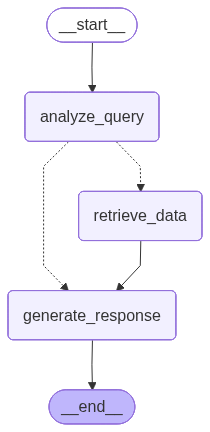


🔍 X-Ray Graph View (shows internal structure):


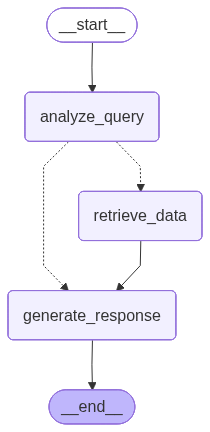


📊 Graph Statistics:
   • Nodes: 5
   • Edges: 5

🔹 Graph Nodes:
   • __start__
   • analyze_query
   • retrieve_data
   • generate_response
   • __end__

🔹 Graph Edges:
   • __start__ → analyze_query
   • analyze_query → generate_response
   • analyze_query → retrieve_data
   • retrieve_data → generate_response
   • generate_response → __end__

✅ Graph visualizations generated successfully!
🎯 The diagrams above show:
   • Standard view: High-level workflow
   • X-ray view: Detailed internal structure
   • Automatic layout and styling
   • Accurate representation of your actual graph


In [17]:
# Import required for image display
from IPython.display import Image, display

def visualize_campaign_assistant_graph():
    """
    Create a visual representation of the campaign assistant graph using LangGraph's built-in visualization.
    This provides an accurate, automatically-generated diagram of the actual graph structure.
    """
    try:
        print("🎨 Generating LangGraph visualization...")
        
        # Method 1: Standard graph visualization
        print("📊 Standard Graph View:")
        standard_graph = campaign_assistant.get_graph()
        display(Image(standard_graph.draw_mermaid_png()))
        
        print("\n🔍 X-Ray Graph View (shows internal structure):")
        # Method 2: X-ray view shows more detailed internal structure
        xray_graph = campaign_assistant.get_graph(xray=True)
        display(Image(xray_graph.draw_mermaid_png()))
        
        # Display graph statistics
        print(f"\n📊 Graph Statistics:")
        print(f"   • Nodes: {len(standard_graph.nodes)}")
        print(f"   • Edges: {len(standard_graph.edges)}")
        
        # Show node details
        print(f"\n🔹 Graph Nodes:")
        for node in standard_graph.nodes:
            print(f"   • {node}")
            
        print(f"\n🔹 Graph Edges:")
        for edge in standard_graph.edges:
            print(f"   • {edge.source} → {edge.target}")
        
        return standard_graph, xray_graph
        
    except Exception as e:
        print(f"❌ Error generating graph visualization: {e}")
        print("💡 Tip: Make sure the graph is compiled successfully before visualization")
        
        # Fallback: show graph structure as text
        print(f"\n📋 Graph Structure (Text View):")
        try:
            nodes = list(workflow.nodes.keys())
            print(f"   Nodes: {', '.join(nodes)}")
        except:
            print("   Could not retrieve node information")
        
        return None, None

# Generate the visualizations
print("🎨 Creating LangGraph visualizations...")
standard_viz, xray_viz = visualize_campaign_assistant_graph()

if standard_viz:
    print("\n✅ Graph visualizations generated successfully!")
    print("🎯 The diagrams above show:")
    print("   • Standard view: High-level workflow")
    print("   • X-ray view: Detailed internal structure")
    print("   • Automatic layout and styling")
    print("   • Accurate representation of your actual graph")
else:
    print("\n⚠️ Visualization failed - check graph compilation")

## 🧪 Interactive Testing

Let's test our campaign assistant with different types of queries to see how it handles various scenarios.

In [19]:
def test_campaign_assistant(query: str, verbose: bool = True):
    """
    Test the campaign assistant with a user query.
    """
    if verbose:
        print(f"🔍 Testing Query: '{query}'")
        print("=" * 50)
    
    # Create initial state
    initial_state = CampaignAssistantState(
        messages=[HumanMessage(content=query)],
        user_query=query,
        query_type="",
        extracted_entities={},
        relevant_data={},
        data_sources=[],
        response="",
        charts_generated=[],
        current_step="start",
        needs_data=False,
        error_message=None
    )
    
    try:
        # Run the graph
        result = campaign_assistant.invoke(initial_state)
        
        if verbose:
            print(f"✅ Processing complete!")
            print(f"📊 Query Type: {result['query_type']}")
            print(f"🔄 Final Step: {result['current_step']}")
            print(f"📈 Data Sources: {result.get('data_sources', [])}")
            print(f"📊 Charts: {result.get('charts_generated', [])}")
            print("\n" + "="*50)
            print("📋 RESPONSE:")
            print("="*50)
            display(Markdown(result['response']))
            print("\n")
        
        return result
        
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

# Test different query types
test_queries = [
    "Show me the performance metrics for our recent campaigns",
    "Compare the summer sale campaign with the black friday campaign", 
    "What can you help me with?",
    "Analyze the conversion trends for Q4 campaigns"
]

print("🚀 Running Test Suite")
print("=" * 50)

results = []
for i, query in enumerate(test_queries, 1):
    print(f"\n📝 Test {i}:")
    result = test_campaign_assistant(query)
    results.append(result)
    print("\n" + "-" * 50)

print(f"\n✅ All tests completed! {len([r for r in results if r])} successful out of {len(test_queries)}")

🚀 Running Test Suite

📝 Test 1:
🔍 Testing Query: 'Show me the performance metrics for our recent campaigns'
🔍 Analyzing user query...
   Query type: performance
   Needs data: True
   Entities: {'campaigns': ['campaign_1', 'campaign_2']}
📊 Retrieving campaign data...
   Retrieved data for 2 campaigns
   Data sources: ['campaign_database', 'analytics_api']
💬 Generating response...
   Generated response (428 characters)
   Charts suggested: ['performance_overview', 'campaign_comparison']
✅ Processing complete!
📊 Query Type: performance
🔄 Final Step: response_generated
📈 Data Sources: ['campaign_database', 'analytics_api']
📊 Charts: ['performance_overview', 'campaign_comparison']

📋 RESPONSE:


## 📈 Campaign Performance Summary

Based on your query: *Show me the performance metrics for our recent campaigns*

### Overall Metrics
- **Total Spend**: $40,000
- **Total Conversions**: 470
- **Average CTR**: 2.00%

### Campaign Details
**Summer Sale 2024**
- Spend: $15,000
- Conversions: 150
- CTR: 2.0%
- Conversion Rate: 3.0%

**Black Friday 2024**
- Spend: $25,000
- Conversions: 320
- CTR: 2.0%
- Conversion Rate: 4.0%






--------------------------------------------------

📝 Test 2:
🔍 Testing Query: 'Compare the summer sale campaign with the black friday campaign'
🔍 Analyzing user query...
   Query type: comparison
   Needs data: True
   Entities: {'campaigns': ['campaign_1', 'campaign_2']}
📊 Retrieving campaign data...
   Retrieved data for 2 campaigns
   Data sources: ['campaign_database', 'analytics_api']
💬 Generating response...
   Generated response (163 characters)
   Charts suggested: ['comparison_chart']
✅ Processing complete!
📊 Query Type: comparison
🔄 Final Step: response_generated
📈 Data Sources: ['campaign_database', 'analytics_api']
📊 Charts: ['comparison_chart']

📋 RESPONSE:


## 🔄 Campaign Comparison

Comparing 2 campaigns:

1. **Summer Sale 2024**: $15,000 spend, 150 conversions
2. **Black Friday 2024**: $25,000 spend, 320 conversions





--------------------------------------------------

📝 Test 3:
🔍 Testing Query: 'What can you help me with?'
🔍 Analyzing user query...
   Query type: general
   Needs data: False
   Entities: {}
💬 Generating response...
   Generated response (228 characters)
   Charts suggested: []
✅ Processing complete!
📊 Query Type: general
🔄 Final Step: response_generated
📈 Data Sources: []
📊 Charts: []

📋 RESPONSE:


## ℹ️ General Information

I can help you analyze campaign performance, compare campaigns, and provide insights.

Try asking about:
- Campaign performance metrics
- Comparison between campaigns
- Analysis of trends and patterns





--------------------------------------------------

📝 Test 4:
🔍 Testing Query: 'Analyze the conversion trends for Q4 campaigns'
🔍 Analyzing user query...
   Query type: performance
   Needs data: True
   Entities: {'campaigns': ['campaign_1', 'campaign_2']}
📊 Retrieving campaign data...
   Retrieved data for 2 campaigns
   Data sources: ['campaign_database', 'analytics_api']
💬 Generating response...
   Generated response (418 characters)
   Charts suggested: ['performance_overview', 'campaign_comparison']
✅ Processing complete!
📊 Query Type: performance
🔄 Final Step: response_generated
📈 Data Sources: ['campaign_database', 'analytics_api']
📊 Charts: ['performance_overview', 'campaign_comparison']

📋 RESPONSE:


## 📈 Campaign Performance Summary

Based on your query: *Analyze the conversion trends for Q4 campaigns*

### Overall Metrics
- **Total Spend**: $40,000
- **Total Conversions**: 470
- **Average CTR**: 2.00%

### Campaign Details
**Summer Sale 2024**
- Spend: $15,000
- Conversions: 150
- CTR: 2.0%
- Conversion Rate: 3.0%

**Black Friday 2024**
- Spend: $25,000
- Conversions: 320
- CTR: 2.0%
- Conversion Rate: 4.0%






--------------------------------------------------

✅ All tests completed! 4 successful out of 4


## 💬 Interactive Query Interface

Try your own queries! Modify the cell below to test the campaign assistant with custom questions.

In [23]:
# 🎯 Try your own query here!
# Change this query to test different scenarios

your_query = "Show me detailed analytics for our top performing campaigns"

print(f"🚀 Running your custom query...")
print(f"💭 Query: '{your_query}'")
print("")

# Execute your query
custom_result = test_campaign_assistant(your_query)

if custom_result:
    print(f"\n🎉 Success! The agent processed your query and generated a response.")
    print(f"📊 Generated {len(custom_result.get('charts_generated', []))} chart recommendations")
else:
    print(f"\n❌ Something went wrong. Check the query format and try again.")

🚀 Running your custom query...
💭 Query: 'Show me detailed analytics for our top performing campaigns'

🔍 Testing Query: 'Show me detailed analytics for our top performing campaigns'
🔍 Analyzing user query...
   Query type: general
   Needs data: False
   Entities: {'campaigns': ['campaign_1', 'campaign_2']}
💬 Generating response...
   Generated response (228 characters)
   Charts suggested: []
✅ Processing complete!
📊 Query Type: general
🔄 Final Step: response_generated
📈 Data Sources: []
📊 Charts: []

📋 RESPONSE:


## ℹ️ General Information

I can help you analyze campaign performance, compare campaigns, and provide insights.

Try asking about:
- Campaign performance metrics
- Comparison between campaigns
- Analysis of trends and patterns





🎉 Success! The agent processed your query and generated a response.
📊 Generated 0 chart recommendations
